## Introduction

Because of memory issues, I moved the EDA into a seperate kernel, [Mask of Steel - EDA & FP Mining](https://www.kaggle.com/ekhtiar/mask-of-steel-eda-fp-mining). In this notebook I we will focus only on implementing a CNN architecture (ResUNet) to identify these defects! The original paper that proposes this architecture is [ResUNet-a: a deep learning framework for semantic segmentation of remotely sensed data](https://arxiv.org/abs/1904.00592).

**If you like my work please upvote this Kernel. This encourages or motivates people like me, who contributes to Kaggle on their own time with the intention to share knowledge, to continue the effort. Furthermore, if I made a mistake or can do something more, please leave a comment in the comments section to help me out. Many thanks in advance!**

#### Experiment Log

1. After pre-training our model for 50 epoch, I managed to load that and make a submission in this version of the [kernel](https://www.kaggle.com/ekhtiar/eda-resunet-tensorflow-keras?scriptVersionId=18052749). In this kernel we just had 5 additional epochs on top of the pre-trained model and the score was 0.71469.
2. I switched to grayscale from RGB, and re-ran the experiment from point 2 in this [kernel](https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow?scriptVersionId=18651595). This made no difference, so we are switching to grayscale. 
3. I increased the number of filters by a factor of 32, to see if having a huge number of filters per layer would improve performance. This rather lowered the scor to 0.68188, and you can see it in this [kernel](https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow?scriptVersionId=18672228).
4. I used standardized values of the input image in this [kernel](https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow?scriptVersionId=18751443), which lead to a improved the score to 0.83109. 
5. Its very obvious that for Image class 3 we are doing a very good job. For the rest of the classes, we are not even being triggered. This is due to the imbalance in our classes. By just repeating the examples with fewer representation multiple times, in this [kernel](https://www.kaggle.com/ekhtiar/mask-eda-fp-mining-and-resunet-a-baseline?scriptVersionId=18276330) we were able to make predictions for class 4 as well as 3. However, class 1 and class 2 was still not predicted by the network. This is probably due to the fact the area for class 1 and 2 is very tiny. However, the score was very poor (0.60075), and can be seen in this [kernel](https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow?scriptVersionId=18320089). Obviously this is due to overfitting, and we need to augment our samples as we repeat them. 

PS: *Be careful with submission of this Kernel, as it is very prone to throwing Kernen threw exception error. It is very hard to debug it as it doesn't provide any logs!!! That is why I had to make so many changes in between version 16 to 19. I had to turn off the IoU score calculation part for it to work. The train set for this Kernel is much larger than the one provided, and for submission of the score, it will run it over the full test set. So becareful about running out of memory, I guess.*

#### Imports

In [19]:
# some basic imports
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [20]:
# imports for building the network
import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

#### Configurations

In [21]:
# Kernel Configurations
make_submission = False # used to turn off lengthy model analysis so a submission version doesn't run into memory error
load_pretrained_model = True # load a pre-trained model
save_model = True # save the model after training
train_dir = 'data' # directory of training images
# pretrained_model_path = '../input/severstal-pretrained-model/ResUNetSteel_z.h5' # path of pretrained model
# model_save_path = './ResUNetSteel_w800e50_z.h5' # path of model to save
train_image_dir = os.path.join(train_dir, 'train_images') # 

In [22]:
# network configuration parameters
# original image is 1600x256, so we will resize it
img_w = 800 # resized weidth
img_h = 256 # resized height
batch_size = 12
epochs = 25
# batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .20 # split of training set between train and validation set
# we will repeat the images with lower samples to make the training process more fair
repeat = False
# only valid if repeat is True
class_1_repeat = 1 # repeat class 1 examples x times
class_2_repeat = 1
class_3_repeat = 1
class_4_repeat = 1

#### Load & Transform train.csv

In [23]:
# load full data and label no mask as -1
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv')).fillna(-1)

In [24]:
# image id and class id are two seperate entities and it makes it easier to split them up in two columns
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['ClassId_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
grouped_EncodedPixels = train_df.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)

#### Utility Functions for RLE Encoding & Decoding

In [25]:
# from https://www.kaggle.com/robertkag/rle-to-mask-converter
def rle_to_mask(rle_string,height,width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rleString (str): Description of arg1 
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [26]:
# Thanks to the authors of: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask_to_rle(mask):
    '''
    Convert a mask into RLE
    
    Parameters: 
    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

    Returns: 
    sring: run length encoding 
    '''
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Data Generator

To push the data to our model, we will create a custom data generator. A generator lets us load data progressively, instead of loading it all into memory at once. A custom generator allows us to also fit in more customization during the time of loading the data. As the model is being procssed in the GPU, we can use a custom generator to pre-process images via a generator. At this time, we can also take advantage multiple processors to parallelize our pre-processing.

In [27]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
                 img_h=256, img_w=512, shuffle=True):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        
        for idx, id in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            # standardization of the image
            image_resized -= image_resized.mean()
            image_resized /= image_resized.std()
            
            mask = np.empty((img_h, img_w, 4))
            
            for idm, image_class in enumerate(['1','2','3','4']):
                rle = self.labels.get(id + '_' + image_class)
                # if there is no mask create empty mask
                if rle is None:
                    class_mask = np.zeros((1600, 256))
                else:
                    class_mask = rle_to_mask(rle, width=1600, height=256)
             
                class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                mask[...,idm] = class_mask_resized
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            y[idx,] = mask
        
        # normalize Y
        y = (y > 0).astype(int)
            
        return X, y

In [28]:
# create a dict of all the masks
masks = {}
for index, row in train_df[train_df['EncodedPixels']!=-1].iterrows():
    masks[row['ImageId_ClassId']] = row['EncodedPixels']

In [29]:
# repeat low represented samples more frequently to balance our dataset
if repeat:
    class_1_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='1')]['ImageId'].values
    class_1_img_id = np.repeat(class_1_img_id, class_1_repeat)
    class_2_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='2')]['ImageId'].values
    class_2_img_id = np.repeat(class_2_img_id, class_2_repeat)
    class_3_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='3')]['ImageId'].values
    class_3_img_id = np.repeat(class_3_img_id, class_3_repeat)
    class_4_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='4')]['ImageId'].values
    class_4_img_id = np.repeat(class_4_img_id, class_4_repeat)
    train_image_ids = np.concatenate([class_1_img_id, class_2_img_id, class_3_img_id, class_4_img_id])
else:
    # split the training data into train and validation set (stratified)
    train_image_ids = train_df['ImageId'].unique()

In [30]:
X_train, X_val = train_test_split(train_image_ids, test_size=val_size, random_state=42)
print(train_image_ids)
print(X_train)

['0002cc93b.jpg' '00031f466.jpg' '000418bfc.jpg' ... 'fffe98443.jpg'
 'ffff4eaa8.jpg' 'ffffd67df.jpg']
['e03364e95.jpg' 'db62a970a.jpg' 'da691bc2e.jpg' ... '6cf49f691.jpg'
 '11b1e2910.jpg' '93c5acf9d.jpg']


In [31]:
params = {'img_h': img_h,
          'img_w': img_w,
          'image_dir': train_image_dir,
          'batch_size': batch_size,
          'shuffle': True}

# Get Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

In [32]:
# check out the shapes
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)

(12, 256, 800, 1) (12, 256, 800, 4)


In [33]:
# visualize steel image with four classes of faults in seperate columns
def viz_steel_img_mask(img, masks):
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    for idx, mask in enumerate(masks):
        ax[idx].imshow(img)
        ax[idx].imshow(mask, alpha=0.3, cmap=cmaps[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

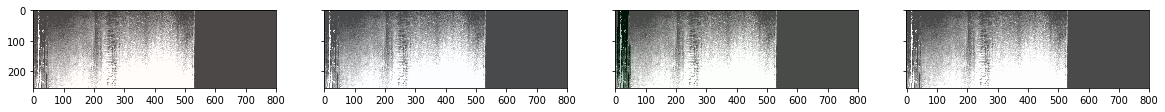

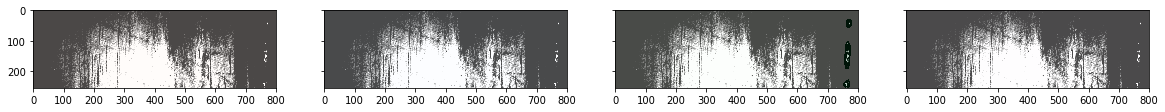

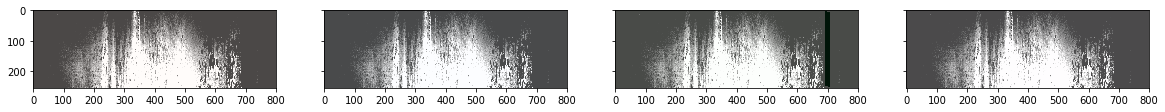

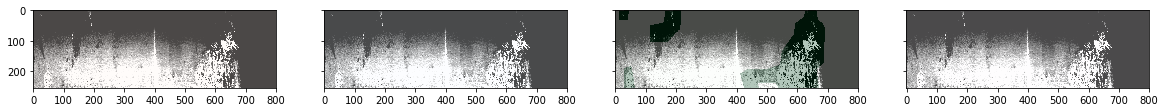

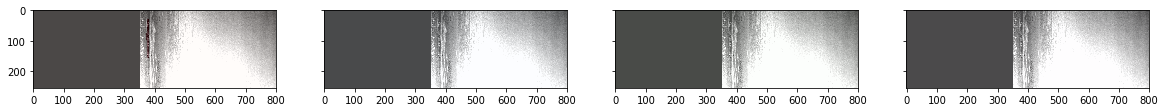

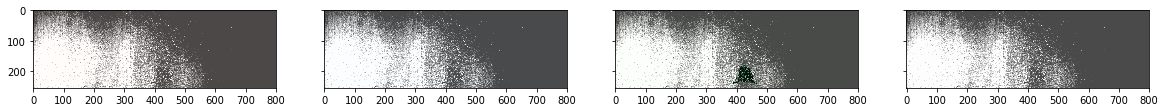

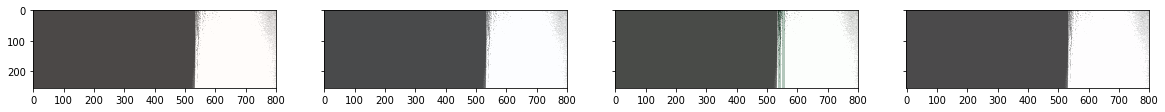

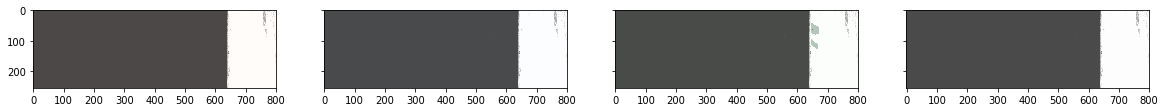

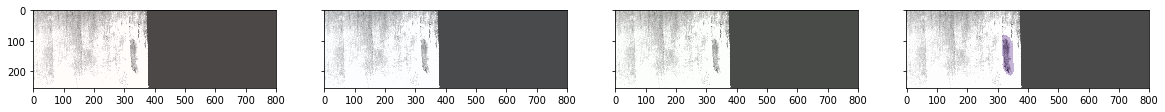

In [34]:
# lets visualize some images with their faults to make sure our data generator is working like it should
for ix in range(0,batch_size):
    if y[ix].sum() > 0:
        img = x[ix]
        masks_temp = [y[ix][...,i] for i in range(0,4)]
        viz_steel_img_mask(img, masks_temp)

## Resunet

In this section we will define the building blocks for our network and train our network.

In [35]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

In [36]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

In [37]:
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output

In [38]:
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

In [39]:
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c

In [40]:
def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

## Loss Functions

As our classes are highly imbalanced and we are stacking four output layers at once, it is even more important to get the loss function right. Here I will aggregate important loss functions so you can reuse and experiment with them along with me.

In [41]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [42]:
# Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

## Compile & Fit The Model

In [43]:
model = ResUNet(img_h=img_h, img_w=img_w)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[tversky])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [44]:
if load_pretrained_model:
    try:
        model.load_weights(pretrained_model_path)
        print('pre-trained model loaded!')
    except OSError:
        print('You need to run the model and load the trained model')

NameError: name 'pretrained_model_path' is not defined

In [ ]:
history = model.fit_generator(training_generator, epochs=epochs, verbose=1)

Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
if save_model: 
    model.save(model_save_path)

## Model Insights

In this section we take a look at the performance of our model and visually inspect how our predictions look like.

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky'])


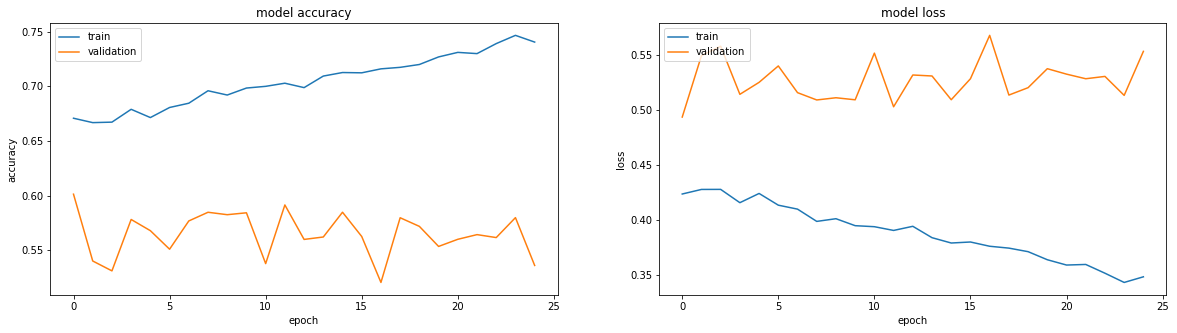

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['tversky'])
plt.plot(history.history['val_tversky'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [30]:
# a function to plot image with mask and image with predicted mask next to each other
def viz_single_fault(img, mask, pred, image_class):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
    
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    
    ax[0].imshow(img)
    ax[0].imshow(mask, alpha=0.3, cmap=cmaps[image_class-1])
    ax[0].set_title('Mask - Defect Class %s' % image_class)
    
    ax[1].imshow(img)
    ax[1].imshow(pred, alpha=0.3, cmap=cmaps[image_class-1])
    ax[1].set_title('Predicted Mask - Defect Class %s' % image_class)
    
    plt.show()

To get a better understanding of our model we will calculate the IoU score. If you are unfamiliar with the concept of IoU, you can read more of it here: http://ronny.rest/tutorials/module/localization_001/iou/.

In [31]:
# https://www.jeremyjordan.me/evaluating-image-segmentation-models/
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    if np.sum(union) == 0:
        iou_score = 0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

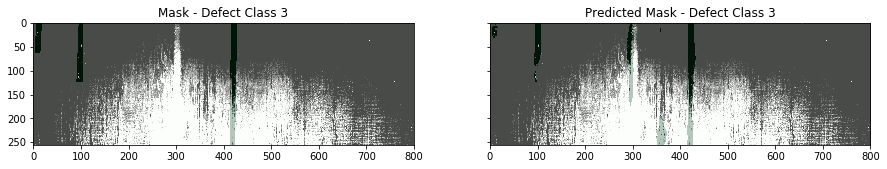

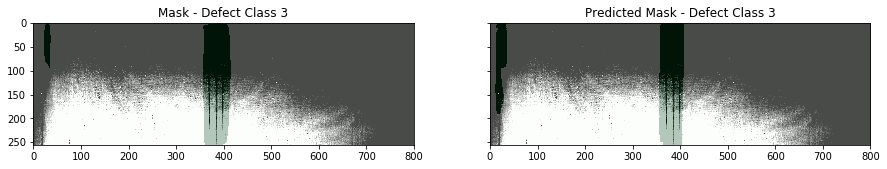

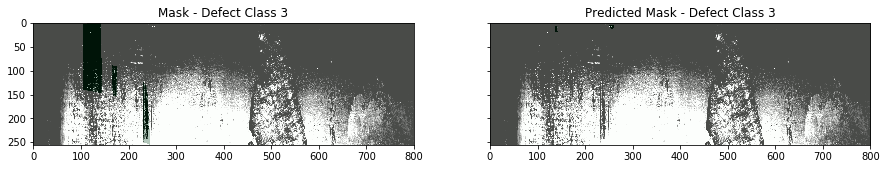

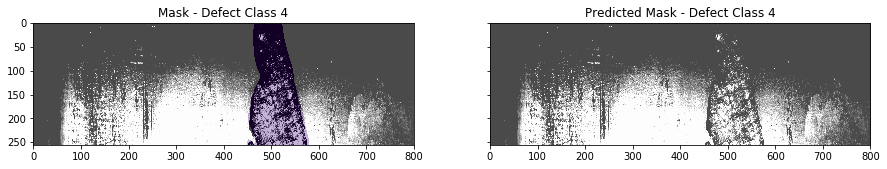

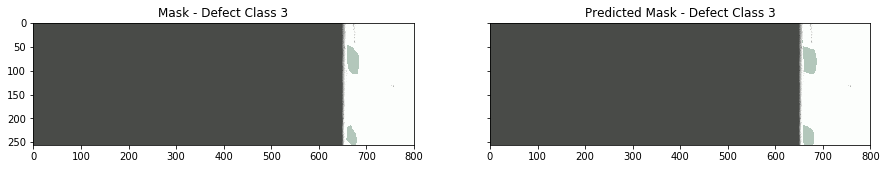

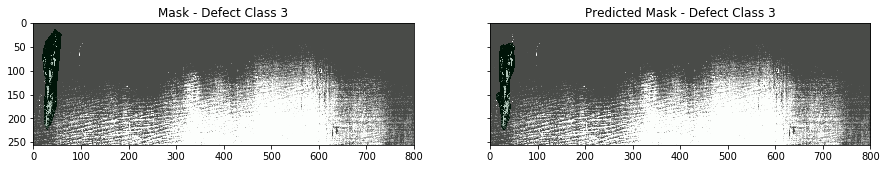

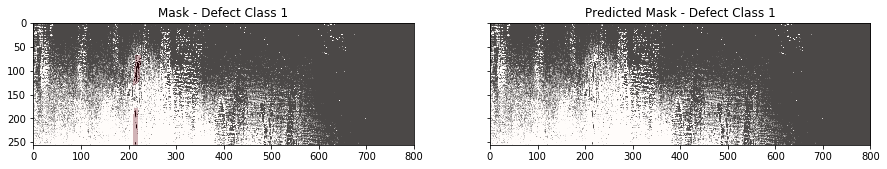

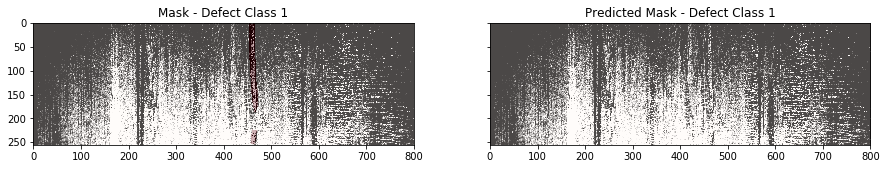

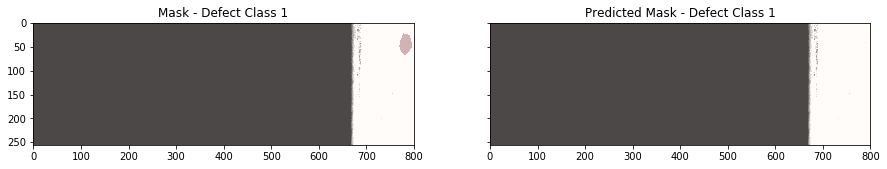

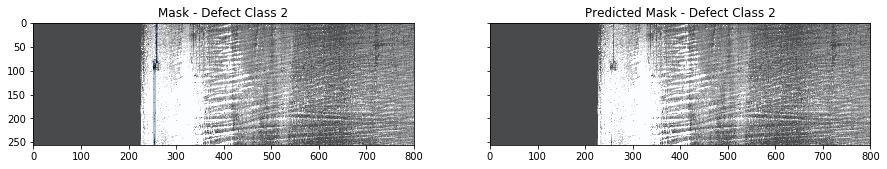

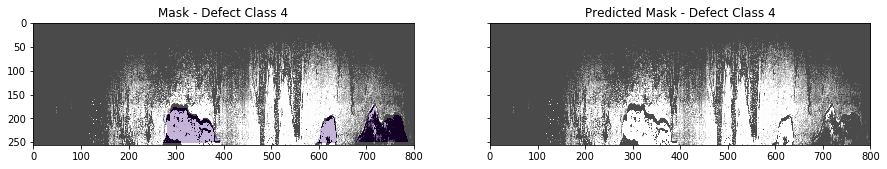

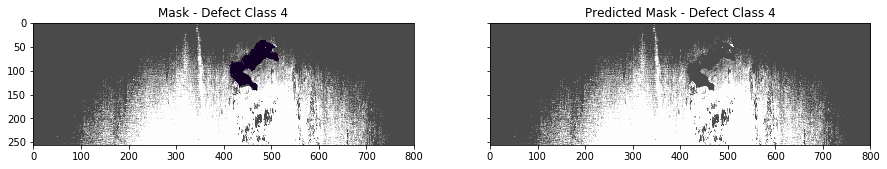

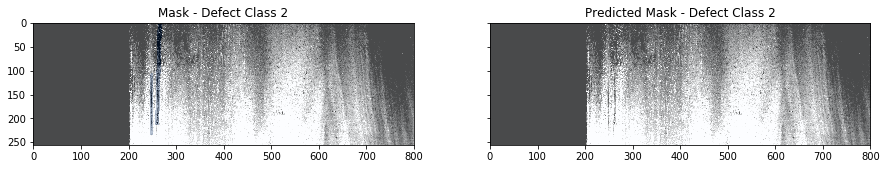

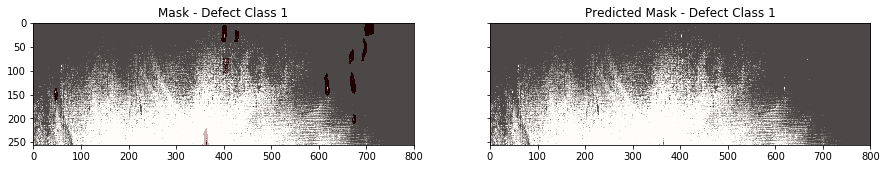

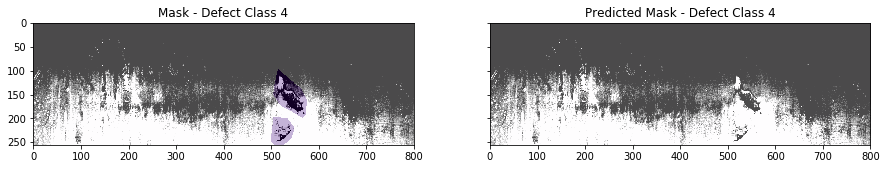

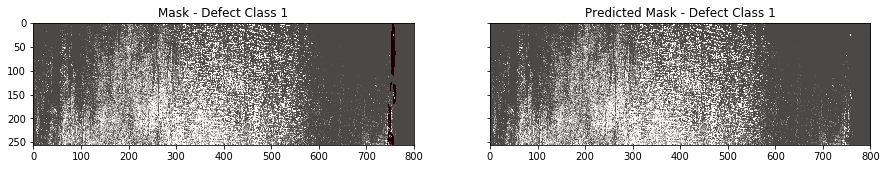

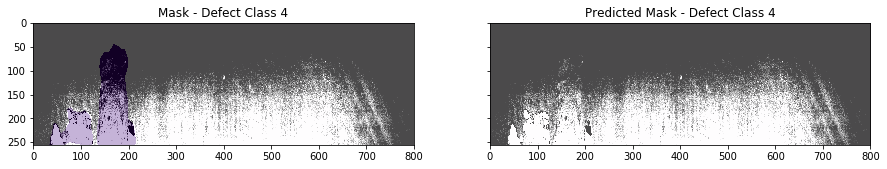

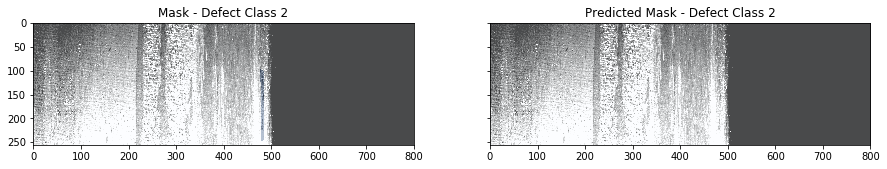

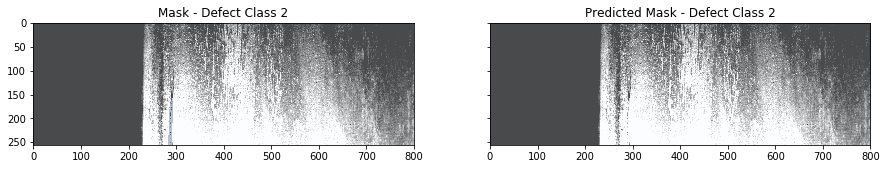

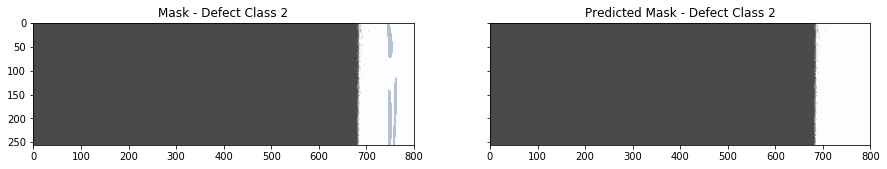

In [32]:
if make_submission == False:
    # lets loop over the predictions and print 5 of each image cases with defects
    count = 0
    # a list to keep count of the number of plots made per image class
    class_viz_count = [0,0,0,0]
    # to keep the total iou score per image class
    class_iou_score = [0, 0, 0, 0]
    # to keep sum of mask pixels per image class
    class_mask_sum = [0, 0, 0, 0]
    # to keep sum of predicted mask pixels per image class
    class_pred_sum = [0, 0, 0, 0]

    # loop over to all the batches in one epoch 
    for i in range(0, validation_generator.__len__()):
        # get a batch of image, true mask, and predicted mask
        x, y = validation_generator.__getitem__(i)
        predictions = model.predict(x)

        # loop through x to get all the images in the batch
        for idx, val in enumerate(x):
            # we are only interested if there is a fault. if we are dropping images with no faults before this will become redundant
            if y[idx].sum() > 0: 
                # get an image and convert to make it matplotlib.pyplot friendly
                img = x[idx]
                img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
                # loop over the four ourput layers to create a list of all the masks for this image
                masks_temp = [y[idx][...,i] for i in range(0,4)]
                # loop over the four output layers to create a list of all the predictions for this image
                preds_temp = [predictions[idx][...,i] for i in range(0,4)]
                # turn to binary (prediction) mask 
                preds_temp = [p > .5 for p in preds_temp]

                for i, (mask, pred) in enumerate(zip(masks_temp, preds_temp)):
                    image_class = i + 1
                    class_iou_score[i] += calculate_iou(mask, pred)
                    class_mask_sum[i] += mask.sum()
                    class_pred_sum[i] += pred.sum()
                    if mask.sum() > 0 and class_viz_count[i] < 5:
                        viz_single_fault(img, mask, pred, image_class)
                        class_viz_count[i] += 1

Visualize the IoU, Sum of pixel for mask given, and sum of pixel for the prediction to better understand the performance of our model.

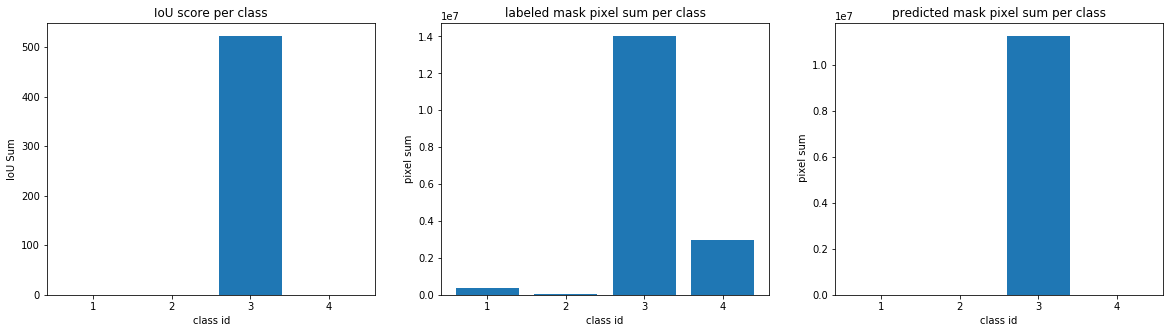

In [33]:
 if make_submission == False:
    class_ids = [1,2,3,4]
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    y_pos = np.arange(len(class_ids))
    plt.bar(y_pos, class_iou_score)
    plt.xticks(y_pos, class_ids)
    plt.title('IoU score per class')
    plt.ylabel('IoU Sum')
    plt.xlabel('class id')
    plt.subplot(1,3,2)
    plt.bar(y_pos, class_mask_sum)
    plt.xticks(y_pos, class_ids)
    plt.title('labeled mask pixel sum per class')
    plt.ylabel('pixel sum')
    plt.xlabel('class id')
    plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
    plt.subplot(1,3,3)
    plt.bar(y_pos, class_pred_sum)
    plt.xticks(y_pos, class_ids)
    plt.title('predicted mask pixel sum per class')
    plt.ylabel(' pixel sum')
    plt.xlabel('class id')
    plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
    plt.show()

Its obviously and unfortunately clear that we don't see enough sample of the other classes so we don't make a any prediction on them. I do wish we made some prediciton on class 4 but oh well, life building AI isn't easy =( 

## Making Predictions & Submission File

Now that our model is trained lets make a submission and file it in!

In [34]:
# return tensor in the right shape for prediction 
def get_test_tensor(img_dir, img_h, img_w, channels=1):

    X = np.empty((1, img_h, img_w, channels))
    # Store sample
    image = cv2.imread(img_dir, 0)
    image_resized = cv2.resize(image, (img_w, img_h))
    image_resized = np.array(image_resized, dtype=np.float64)
    # normalize image
    image_resized -= image_resized.mean()
    image_resized /= image_resized.std()
    
    X[0,] = np.expand_dims(image_resized, axis=2)

    return X

In [35]:
# this is an awesome little function to remove small spots in our predictions

from skimage import morphology

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [36]:
import glob
# get all files using glob
test_files = [f for f in glob.glob('../input/severstal-steel-defect-detection/test_images/' + "*.jpg", recursive=True)]

In [37]:
submission = []

# a function to apply all the processing steps necessery to each of the individual masks
def process_pred_mask(pred_mask):
    
    pred_mask = cv2.resize(pred_mask.astype('float32'),(1600, 256))
    pred_mask = (pred_mask > .5).astype(int)
    pred_mask = remove_small_regions(pred_mask, 0.02 * np.prod(512)) * 255
    pred_mask = mask_to_rle(pred_mask)
    
    return pred_mask

# loop over all the test images
for f in test_files:
    # get test tensor, output is in shape: (1, 256, 512, 3)
    test = get_test_tensor(f, img_h, img_w) 
    # get prediction, output is in shape: (1, 256, 512, 4)
    pred_masks = model.predict(test) 
    # get a list of masks with shape: 256, 512
    pred_masks = [pred_masks[0][...,i] for i in range(0,4)]
    # apply all the processing steps to each of the mask
    pred_masks = [process_pred_mask(pred_mask) for pred_mask in pred_masks]
    # get our image id
    id = f.split('/')[-1]
    # create ImageId_ClassId and get the EncodedPixels for the class ID, and append to our submissions list
    [submission.append((id+'_%s' % (k+1), pred_mask)) for k, pred_mask in enumerate(pred_masks)]

/opt/conda/lib/python3.6/site-packages/skimage/morphology/misc.py:208: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
/opt/conda/lib/python3.6/site-packages/skimage/morphology/misc.py:132: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [38]:
# convert to a csv
submission_df = pd.DataFrame(submission, columns=['ImageId_ClassId', 'EncodedPixels'])
# check out some predictions and see if RLE looks ok
submission_df[ submission_df['EncodedPixels'] != ''].head()

,ImageId_ClassId,EncodedPixels
6,d5e8bbe9a.jpg_3,329342 5 329598 5 329853 6 330109 6 330365 7 3...
10,874f5fe53.jpg_3,244455 5 244461 1 244466 2 244710 8 244719 6 2...
14,64273b706.jpg_3,71 53 212 12 327 53 381 2 468 13 581 60 711 2 ...
18,e8a1e41ef.jpg_3,280253 8 280287 1 280509 8 280543 1 280764 15 ...
22,f7c7e853c.jpg_3,281690 1 281946 1 282201 2 282457 3 282712 4 2...


In [39]:
# take a look at our submission 
submission_df.head()

,ImageId_ClassId,EncodedPixels
0,b51cdf84f.jpg_1,
1,b51cdf84f.jpg_2,
2,b51cdf84f.jpg_3,
3,b51cdf84f.jpg_4,
4,d5e8bbe9a.jpg_1,


In [40]:
# write it out
submission_df.to_csv('./submission.csv', index=False)

Okay guys! This is just a start and hopefully a good start. I will be back soon with update to make this much more professional. For EDA, check out my other Kernel for this competition [Mask of Steel - EDA & FP Mining](https://www.kaggle.com/ekhtiar/mask-of-steel-eda-fp-mining).

**If you like my work please upvote this Kernel. This encourages or motivates people like me, who contributes to Kaggle on their own time with the intention to share knowledge, to continue the effort. Furthermore, if I made a mistake or can do something more, please leave a comment in the comments section to help me out. Many thanks in advance!**